# ***Very Important download dataset from this link before persuing the execution of cells***

https://drive.google.com/drive/folders/1-62-gtVRANF5a5ylnFrYO1Y--q-OiFgr

# **Import the necessary packages**


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# **Initialize the initial learning rate, number of epochs to train for, and batch size**


In [27]:
INIT_LR = 1e-4
# You can play with the number of epochs but 15 is enough
# because we are usinga pretained model as base model
EPOCHS = 15
BS = 32


In [5]:
# Loop through the datasets inside the directory.
DIRECTORY = r"Face-Mask-Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]


In [6]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


# **Loop though the CATEGORIES.**

In [7]:
# Create empty lists data & labels.
# Append all images into the data list
# Apples image lables (with/without mask) into the label list
data = []
labels = []

In [8]:

for category in CATEGORIES:
	#Using os.path.join, join the directory and the category. I.e. Directory\with Mask, Directory/without Mask
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path): #os.listdir lists all the images in the directory.
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224)) #Reference Package Module: from tensorflow.keras.preprocessing.image import load_img. Set the target size to 224x224. This makes the model consistent.
    	image = img_to_array(image) #Reference Package Module: from tensorflow.keras.preprocessing.image import img_to_array. This converts the images to array.
    	image = preprocess_input(image) #This is related to mobilenets functionality.

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [9]:
# Now we have all the data (images) as Numerical values. But the labels (categories) are still alphabetical values (with/without mask).
# Perform one-hot encoding on the labels
lb = LabelBinarizer() #Reference Package Module: sklearn.preprocessing import LabelBinarizer
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
#Using above functions, we convert the lables to categorical variables.

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [11]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# **Load the MobileNetV2 network, ensuring the head FC layer sets are left off**

In [12]:

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


9412608/9406464 [==============================] - 0s 0us/step


# **Construct the head of the model that will be placed on top of the base model**

In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


# **Place the head FC model on top of the base model (this will becomethe actual model we will train)**

In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [17]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/15
95/95 [==============================] - 41s 338ms/step - loss: 0.6070 - accuracy: 0.6941 - val_loss: 0.1577 - val_accuracy: 0.9778
Epoch 2/15
95/95 [==============================] - 31s 325ms/step - loss: 0.1771 - accuracy: 0.9571 - val_loss: 0.0874 - val_accuracy: 0.9857
Epoch 3/15
95/95 [==============================] - 31s 321ms/step - loss: 0.1002 - accuracy: 0.9781 - val_loss: 0.0620 - val_accuracy: 0.9896
Epoch 4/15
95/95 [==============================] - 31s 324ms/step - loss: 0.0837 - accuracy: 0.9763 - val_loss: 0.0529 - val_accuracy: 0.9817
Epoch 5/15
95/95 [==============================] - 31s 323ms/step - loss: 0.0725 - accuracy: 0.9780 - val_loss: 0.0444 - val_accuracy: 0.9909
Epoch 6/15
95/95 [==============================] - 31s 324ms/step - loss: 0.0696 - accuracy: 0.9757 - val_loss: 0.0423 - val_accuracy: 0.9909
Epoch 7/15
95/95 [==============================] - 31s 324ms/step - loss: 0.0562 - accuracy: 0.9885 - val_loss: 0.038

# **Predicting now yeah almost done**

In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...


In [19]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


In [20]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       383
without_mask       0.99      1.00      1.00       384

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767



In [21]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector_version_moez.model", save_format="h5")


[INFO] saving mask detector model...


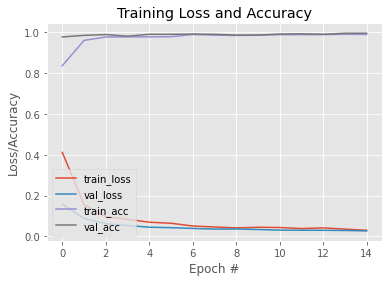

In [22]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# **Wiiiiiw Good model over here almost accuracy 100% on train and test**